# Predict graphs

## Setup

In [2]:
import os
from collections import Counter
import torch
import time
import random
from matplotlib import pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from abc import ABC, abstractmethod
from typing import Set, List, Tuple
from graph_loader import load_graphs
from graph import Graph
from part import Part
from node import Node


In [3]:
# MPS for Metal acceleration for Mac
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu") 
SEED = 0
random.seed(SEED)
# setgrad = lambda g, *ms: [setattr(p,'requires_grad', g) for m in ms for p in m.parameters() ]  

/var/folders/42/x47cnz7x2v98xvk5lhdybbnm0000gn/T/ipykernel_85737/966742386.py:2: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")


In [4]:
# TODO: Create custom dataset

## Visualize

Number of graphs: 11159
Number of connected graphs: 11159
Number of cyclic graphs: 0


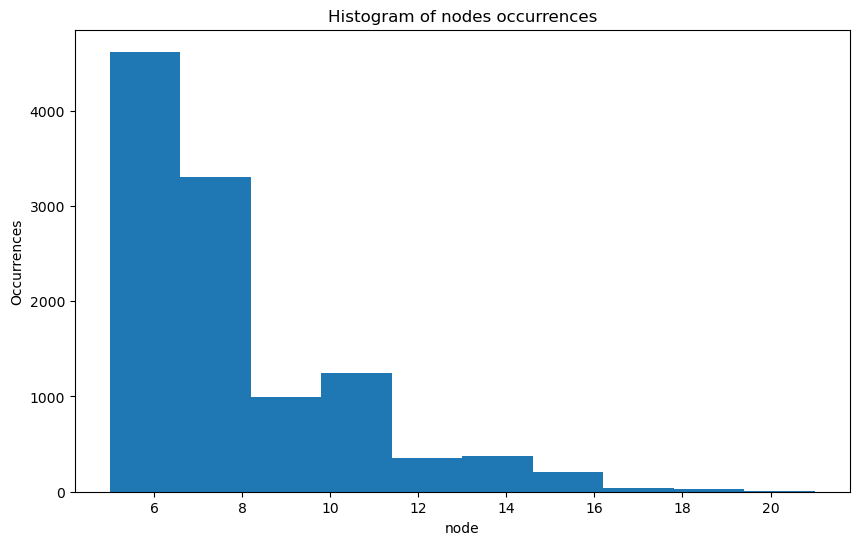

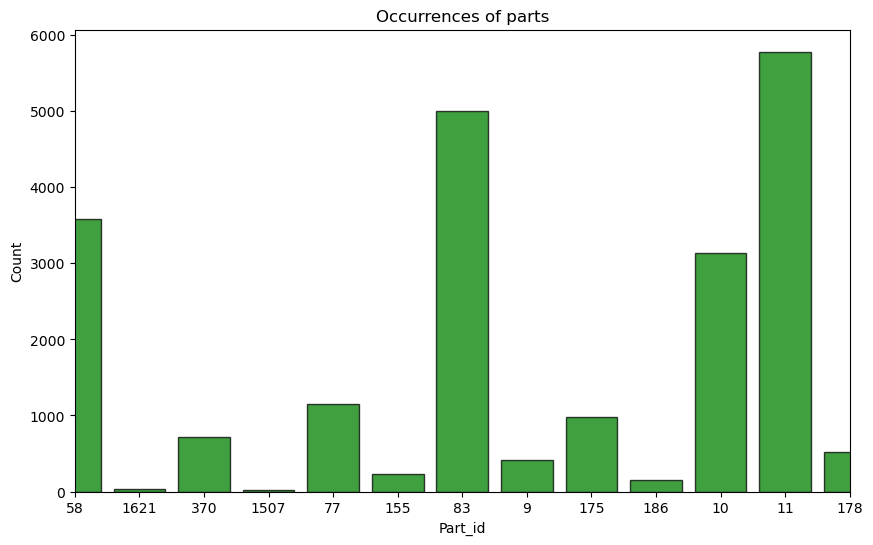

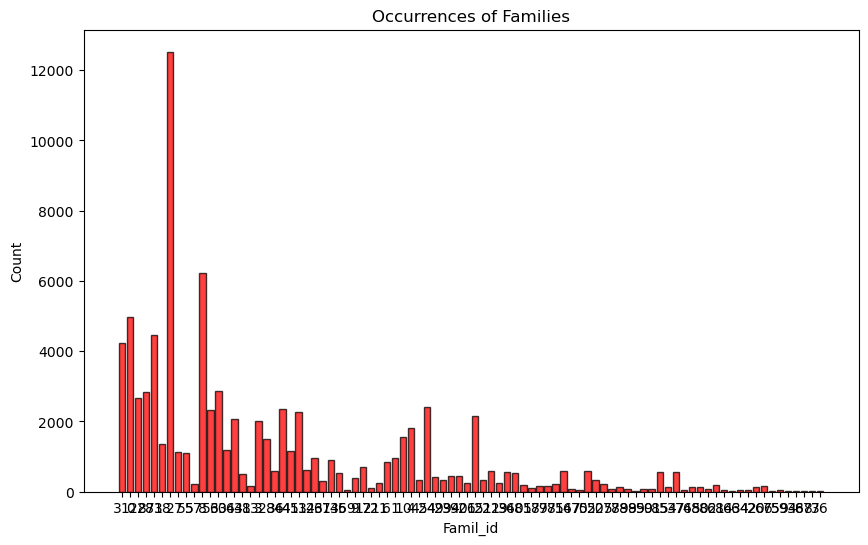

In [ ]:
# descriptive analysis of the dataset
graphs = load_graphs("data/graphs.dat")
'''
graphs[0].draw()
print(graphs[0].get_parts())
print(graphs[0].get_nodes())
'''
number_of_graphs = len(graphs)
number_of_connected_graphs = 0
number_of_cyclic_graphs = 0
number_of_nodes = []
part_id_counter = Counter()
family_id_counter = Counter()
node_id_counter = Counter()


for graph in graphs:
    if graph.is_connected():
        number_of_connected_graphs += 1
    if graph.is_cyclic():
        number_of_cyclic_graphs += 1
    nodes = graph.get_nodes()
    parts = graph.get_parts()    
    number_of_nodes.append(len(nodes))
    for node in nodes:
        node_id_counter[node.get_id] += 1
    for part in parts:
        p_id = part.get_part_id()
        part_id_counter[p_id] += 1
        family_id_counter[part.get_family_id()] += 1
    
# cannot use get_parts method because it returns a set of nodes
print(f"Number of graphs: {number_of_graphs}")
print(f"Number of connected graphs: {number_of_connected_graphs}")
print(f"Number of cyclic graphs: {number_of_cyclic_graphs}")



# Convert the Counter dictionary into two lists:
part_ids, counts = zip(*part_id_counter.items())

plt.figure(figsize=(10, 6))
plt.hist(number_of_nodes)
plt.xlabel("node")
plt.ylabel("Occurrences")
plt.title("Histogram of nodes occurrences")
plt.show()


# TODO: sort the part_ids and counts
parts, counts = zip(*part_id_counter.items())
# Visualization: Bar chart
plt.figure(figsize=(10, 6))
plt.bar(parts, counts, alpha=0.75, color='green', edgecolor='black')
plt.title("Occurrences of parts")
plt.xlabel("Part_id")
plt.ylabel("Count")
plt.xlim(0,12)
plt.show()

family, counts = zip(*family_id_counter.items())
# Visualization: Bar chart
plt.figure(figsize=(10, 6))
plt.bar(family, counts, alpha=0.75, color='red', edgecolor='black')
plt.title("Occurrences of Families")
plt.xlabel("Famil_id")
plt.ylabel("Count")
plt.show()

In [20]:

# Import existing modules
from node import Node
from part import Part
from graph import Graph
from evaluation import MyPredictionModel, evaluate

# Define the GNN model
class GNNModel(MyPredictionModel):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch)  # Pooling
        x = self.fc(x)
        return x

    def predict_graph(self, parts: Set[Part]) -> Graph:
        # Predict a graph using the trained GNN model
        graph = Graph()

        # Create nodes from parts
        nodes = [Node(i, part) for i, part in enumerate(parts)]
        for node in nodes:
            graph.add_node(node)

        # Feature encoding for nodes
        part_features = torch.tensor([[part.part_id, part.family_id] for part in parts], dtype=torch.float)

        # Dummy edge index (e.g., connecting all nodes initially, replace with actual logic)
        edge_index = torch.combinations(torch.arange(len(parts)), r=2).T

        # Prepare PyTorch Geometric Data object
        data = Data(x=part_features, edge_index=edge_index)

        # Predict edge probabilities
        self.eval()
        with torch.no_grad():
            output = self.forward(data)

        # Determine connections based on predictions
        # Here, output can be post-processed to decide edges (e.g., threshold-based)
        edge_probabilities = torch.sigmoid(output)
        threshold = 0.5
        for i, (src, dst) in enumerate(edge_index.T):
            if edge_probabilities[i] > threshold:
                graph.add_edge(nodes[src], nodes[dst])

        return graph


# Main script
if __name__ == "__main__":
    # Load data
    data = read_dat_file("data/graphs.dat")
    print(len(data))
    print(type(data))
    print(type(data[0]))
    print(data[0].get_parts())
    print(data[0].get_nodes())
    print(data[0].get_edges())


    # Prepare dataset
    parts_list, graph_list = zip(*data)
    X_train, X_test, y_train, y_test = train_test_split(parts_list, graph_list, test_size=0.2, random_state=42)

    # Convert data to PyTorch Geometric format (Placeholder)
    train_data = []  # Populate with PyTorch Geometric Data objects
    test_data = []

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

    test_loader = DataLoader(test_data, batch_size=32)

    # Define the model
    model = GNNModel(input_dim=10, hidden_dim=16, output_dim=10)

    # Training loop
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(10):
        model.train()
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            output = model(batch)
            loss = torch.nn.MSELoss()(output, batch.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

    # Evaluate the model
    test_loss = evaluate(model, test_loader)
    print(f"Test Loss: {test_loss}")


11159
<class 'list'>
<class 'graph.Graph'>
{Part(PartID=1621, FamilyID=0), Part(PartID=58, FamilyID=31), Part(PartID=58, FamilyID=31), Part(PartID=58, FamilyID=31), Part(PartID=58, FamilyID=31)}
{Node(NodeID=3, Part=Part(PartID=58, FamilyID=31)), Node(NodeID=0, Part=Part(PartID=1621, FamilyID=0)), Node(NodeID=1, Part=Part(PartID=58, FamilyID=31)), Node(NodeID=4, Part=Part(PartID=58, FamilyID=31)), Node(NodeID=2, Part=Part(PartID=58, FamilyID=31))}
{Node(NodeID=0, Part=Part(PartID=1621, FamilyID=0)): [Node(NodeID=1, Part=Part(PartID=58, FamilyID=31)), Node(NodeID=2, Part=Part(PartID=58, FamilyID=31)), Node(NodeID=3, Part=Part(PartID=58, FamilyID=31)), Node(NodeID=4, Part=Part(PartID=58, FamilyID=31))], Node(NodeID=1, Part=Part(PartID=58, FamilyID=31)): [Node(NodeID=0, Part=Part(PartID=1621, FamilyID=0))], Node(NodeID=2, Part=Part(PartID=58, FamilyID=31)): [Node(NodeID=0, Part=Part(PartID=1621, FamilyID=0))], Node(NodeID=3, Part=Part(PartID=58, FamilyID=31)): [Node(NodeID=0, Part=Part(Pa

TypeError: 'Graph' object is not iterable